In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from hist.stack import Stack

sys.path.append("..")
from HistogramLib.store import HistogramStore
from HistogramLib.plot_manager import PlotManager
from HistogramLib.bokeh.histogram_widget import *
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hists.store import HistogramId
from bokeh_apps.widgets import *

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v43'
histStore = HistogramStore(hist_folder, HistogramId)

In [3]:
colors_cycle = ["tab:blue", "tab:orange", "tab:green"]

In [4]:
def getClue3DProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("Clus3DClusteredEnergy", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy), "mainOrAllTracksters":hist.loc("mainTrackster")}]
        .project("clus3D_energy")
    )
def getClue2DProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("EnergyClustered2DPerEvent", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy)}]
        .project("clus2D_energy_sum")
    )
def getRechitsProjected(datatype, beamEnergy):
    return (
        histStore.get(HistogramId("RechitsTotalEnergyPerEvent", "cmssw", datatype))
        .getHistogram(HistogramKind.COUNT)
        [{"beamEnergy":hist.loc(beamEnergy)}]
        .project("rechits_energy_sum")
    )

In [5]:
histStore.get(HistogramId("RechitsTotalEnergyPerEvent", "cmssw", "data")).getHistogram(HistogramKind.COUNT)

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Regular(2000, 0, 350, name='rechits_energy_sum', label='Total reconstructed energy per event (GeV)'),
  storage=Double()) # Sum: 270056.0 (270059.0 with flow)

In [6]:
def plot(datatype, beamEnergy, xLim=None, rebin=None, xlabel="Reconstructed energy (GeV)", mainTrackster=None, labels=None):
    plt.figure()
    if xLim is None:
        xLim = synchrotronBeamEnergiesMap[beamEnergy] - 40, synchrotronBeamEnergiesMap[beamEnergy]+10
    plt.xlim(xLim)
    hists = [getRechitsProjected(datatype, beamEnergy), getClue2DProjected(datatype, beamEnergy), getClue3DProjected(datatype, beamEnergy)]
    if rebin is not None:
        for i in range(len(hists)):
            hists[i] = hists[i][::hist.tag.rebin(rebin)]
    if labels is None:
        labels = ["Rechits", "CLUE", "CLUE3D\n(main trackster)" if mainTrackster else "CLUE3D"]
    hep.histplot(hists, 
        yerr=False, label=labels, #["Energy reconstructed", "Energy clustered by CLUE", "Energy clustered by CLUE3D"]
        color=colors_cycle, flow="none"
        )
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel("Event count")
    if datatype == "data":
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ Test Beam - "+ str(beamEnergy) + " GeV")
    plt.legend(loc='upper left')

def plotDataSim(h_data:hist.Hist, h_sim:hist.Hist, label_sim:str, beamEnergy, xLim=None, rebin=None, xlabel=None):
    plt.figure()
    if xLim is None:
        xLim = synchrotronBeamEnergiesMap[beamEnergy]*0.8, synchrotronBeamEnergiesMap[beamEnergy]*1.1
    plt.xlim(xLim)
    if rebin is not None:
        h_data = h_data[::hist.rebin(rebin)]
        h_sim = h_sim[::hist.rebin(rebin)]
    h_sim = h_sim * h_data.sum() / h_sim.sum() # norm sim to data
    handle_sim, = hep.histplot(h_sim, yerr=False, label=label_sim, histtype="step", flow="none")
    handle_data, = hep.histplot(h_data, yerr=True, label="Data", histtype="errorbar", color="black", flow="none")
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel("Event count")
    hep.cms.text("Preliminary")
    hep.cms.lumitext("$e^+$ TB - "+ str(beamEnergy) + " GeV")
    plt.legend(loc='upper left', handles=[handle_data[0], handle_sim[0]])

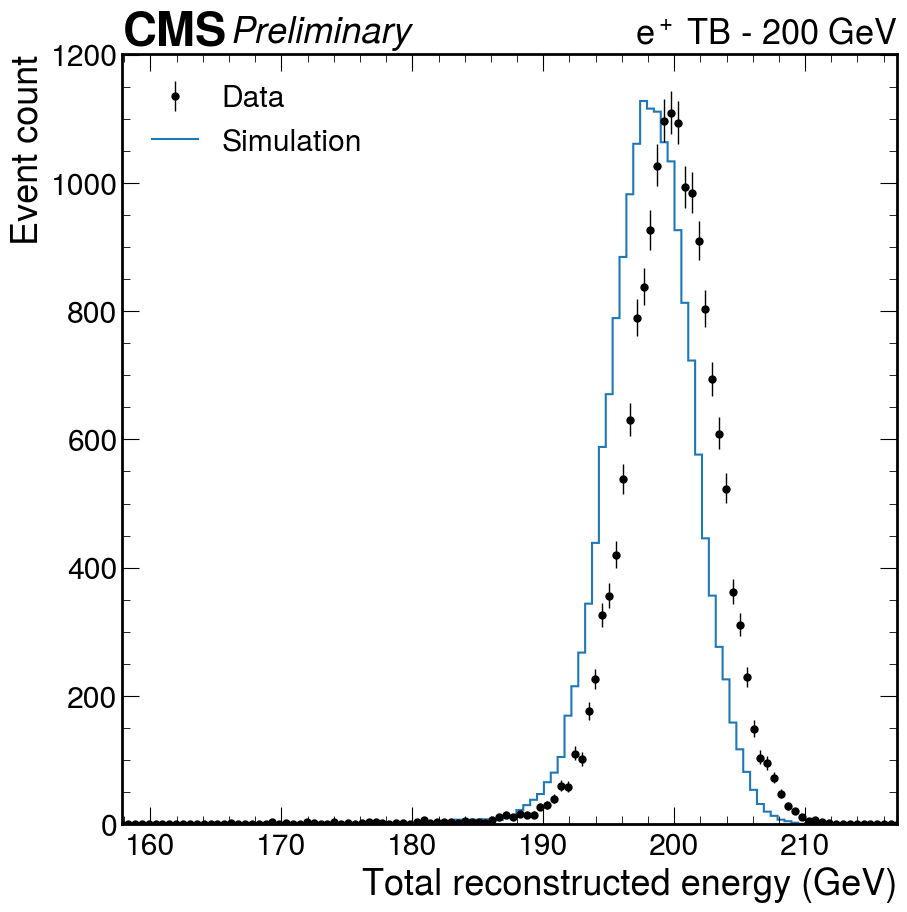

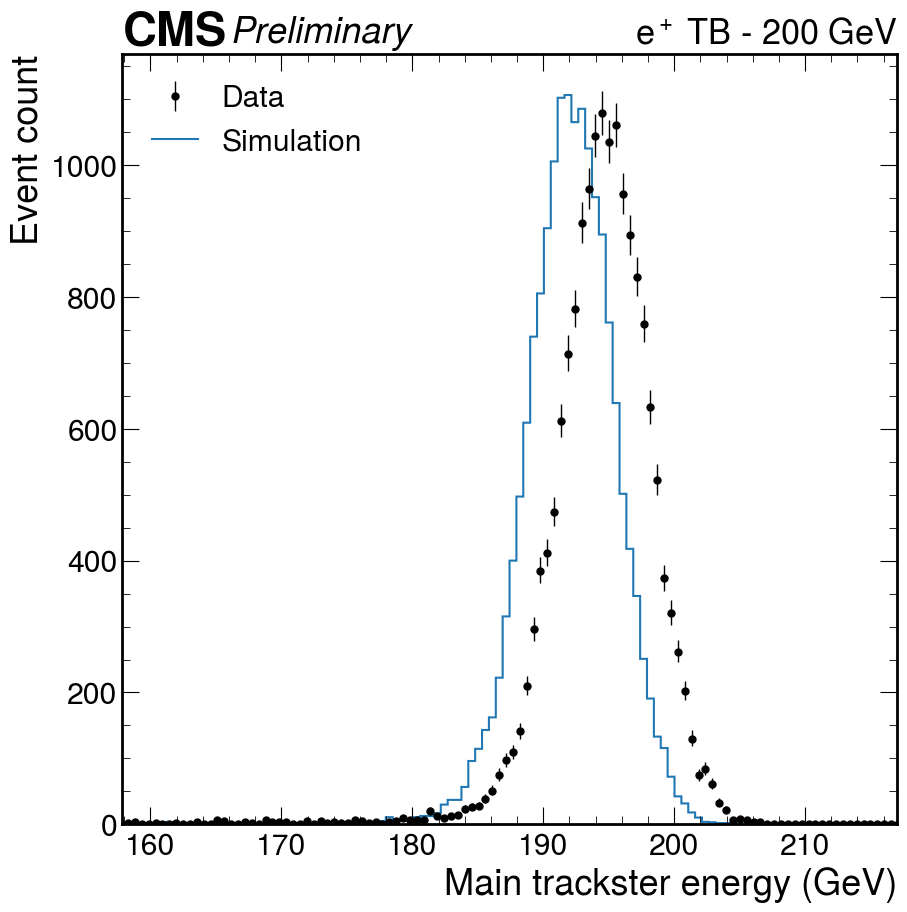

In [7]:
beamEnergy = 200
if beamEnergy < 100:
    rebin = 2
elif beamEnergy < 300:
    rebin = 3
else:
    rebin = 4
plotDataSim(getRechitsProjected("data", beamEnergy),getRechitsProjected("sim_proton_v46_patchMIP", beamEnergy),
            label_sim="Simulation", beamEnergy=beamEnergy, rebin=rebin, xlabel="Total reconstructed energy (GeV)")
plotDataSim(getClue3DProjected("data", beamEnergy),getClue3DProjected("sim_proton_v46_patchMIP", beamEnergy),
            label_sim="Simulation", beamEnergy=beamEnergy, rebin=rebin, xlabel="Main trackster energy (GeV)")
# plt.savefig("energy-distribution-rechits.pdf", bbox_inches="tight")

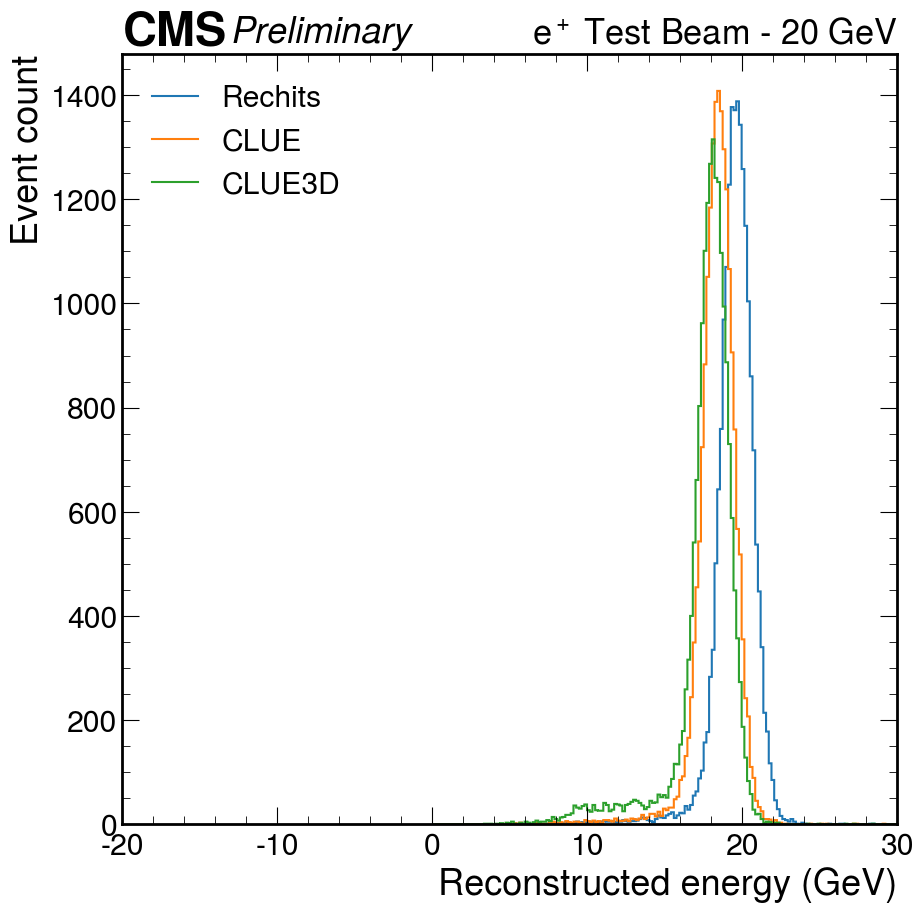

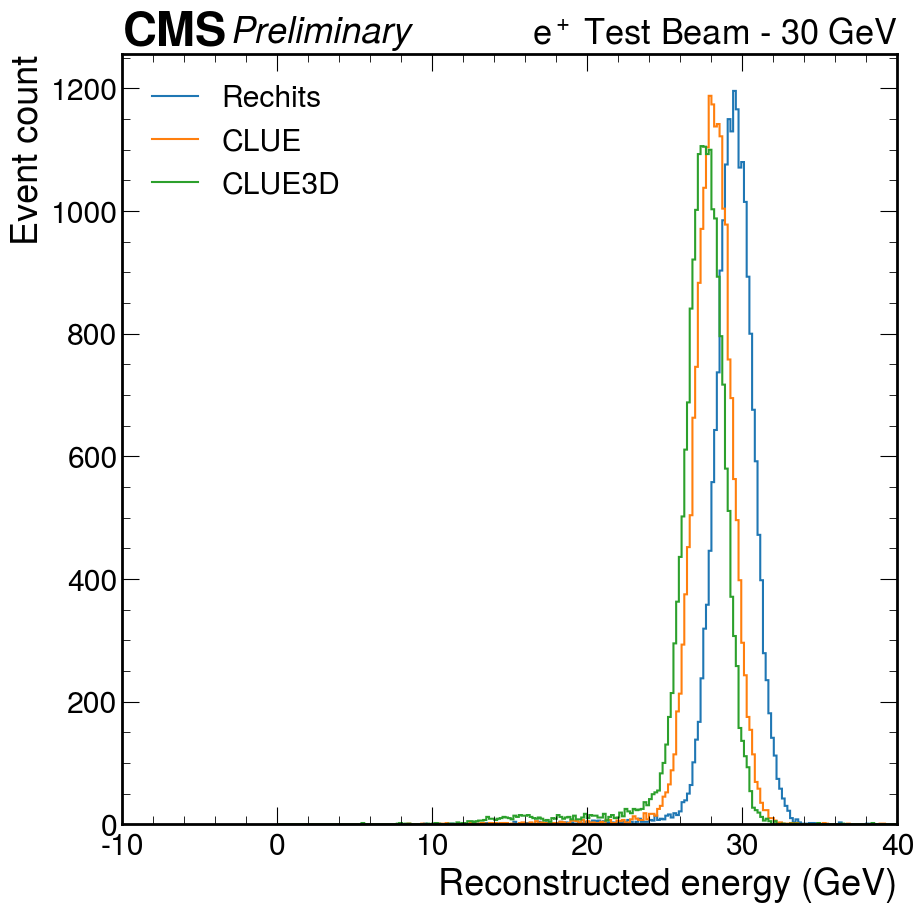

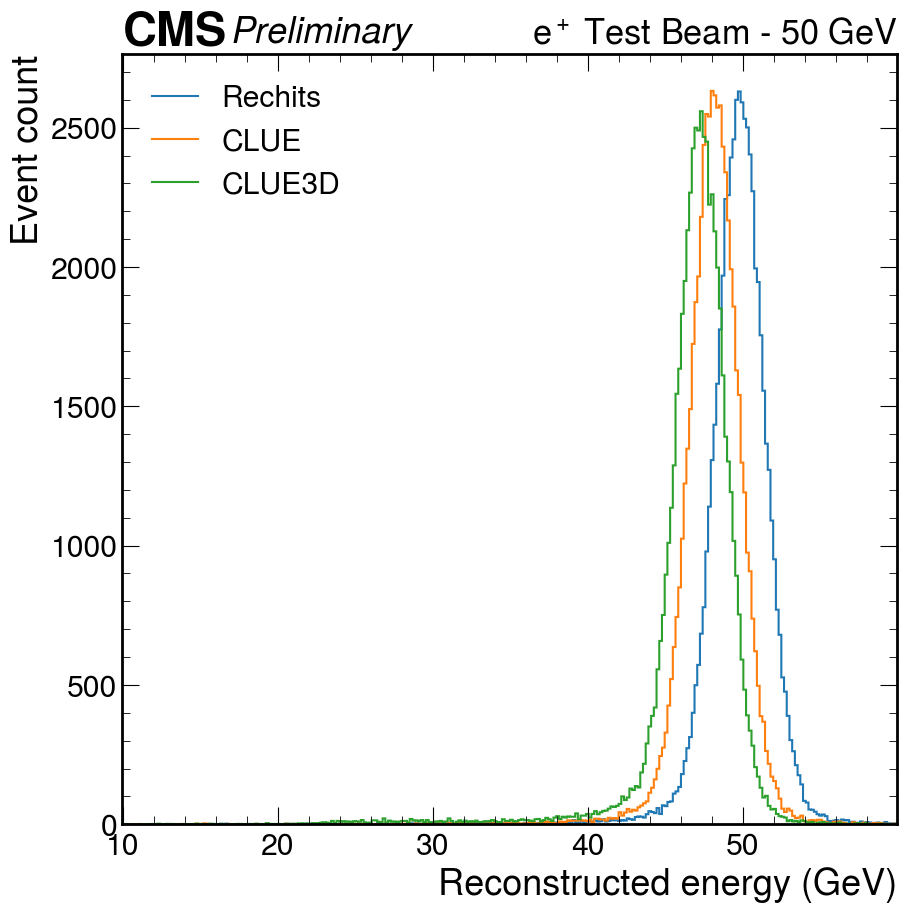

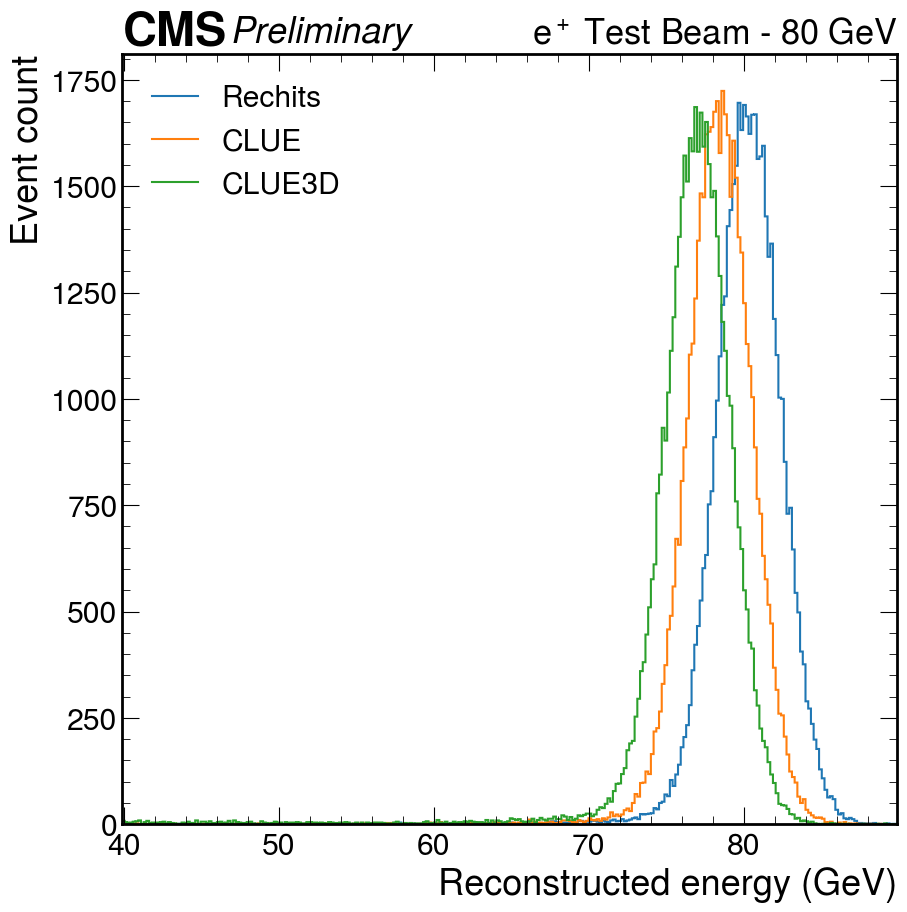

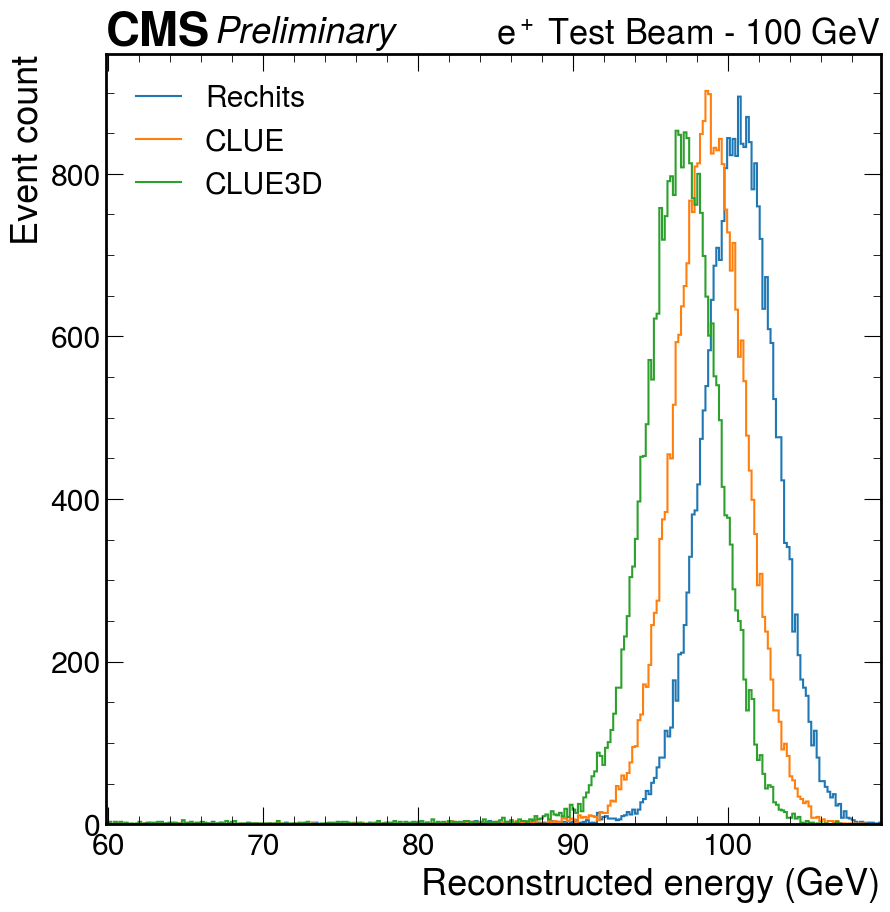

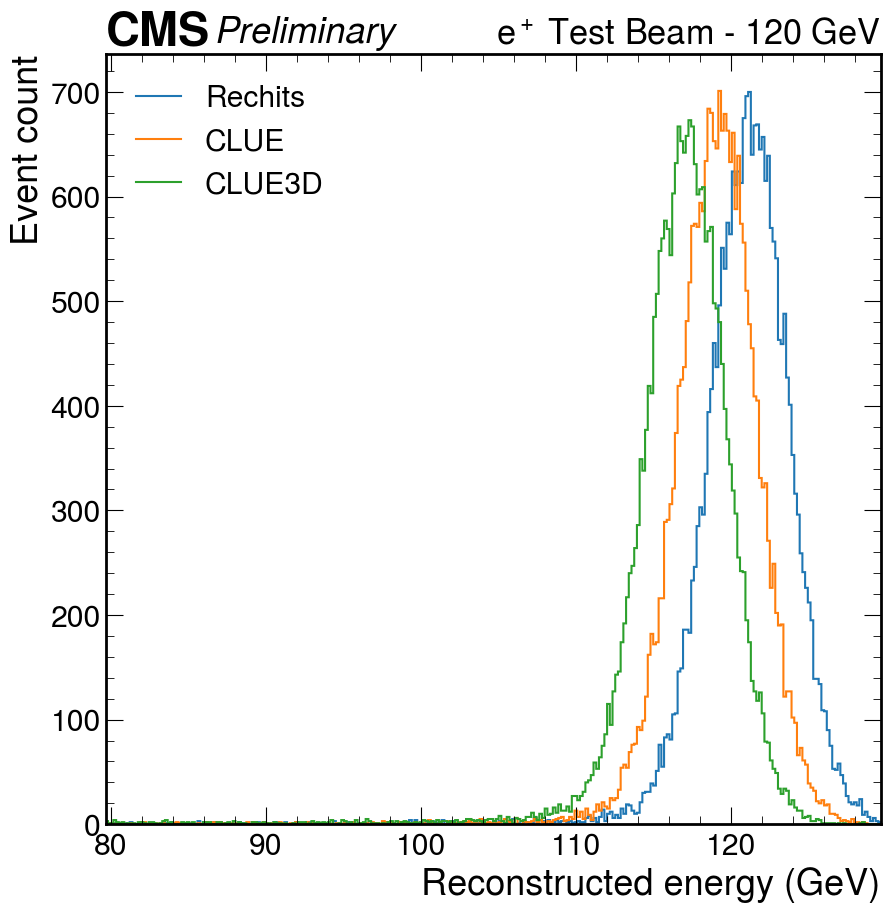

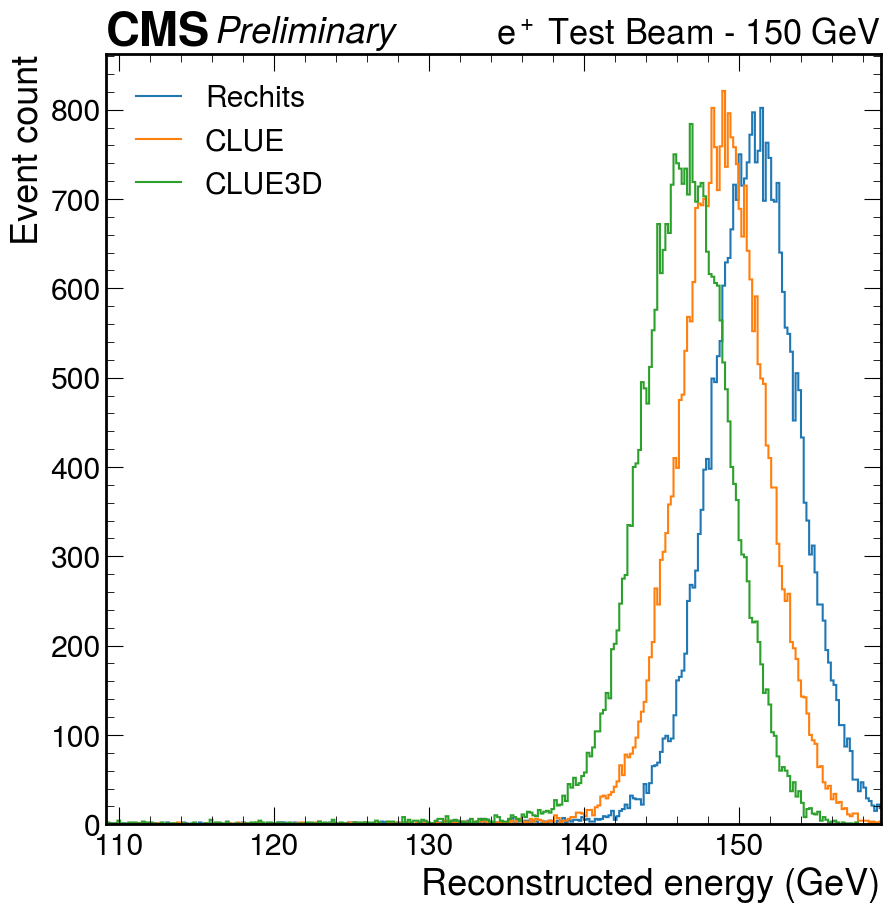

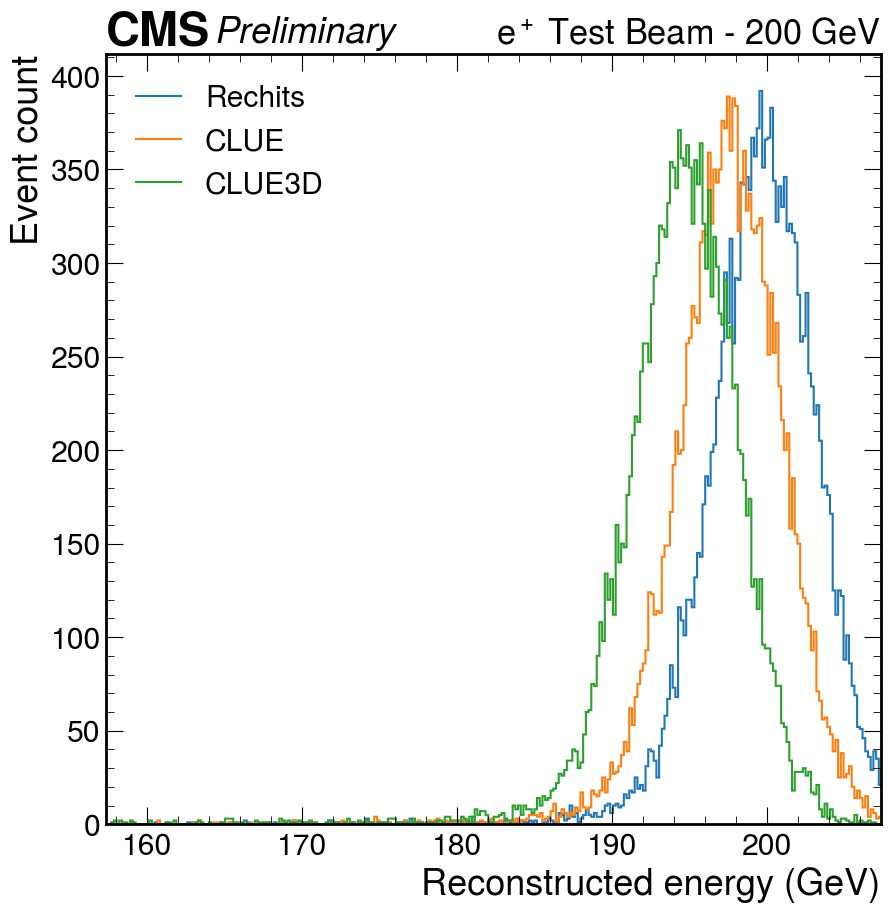

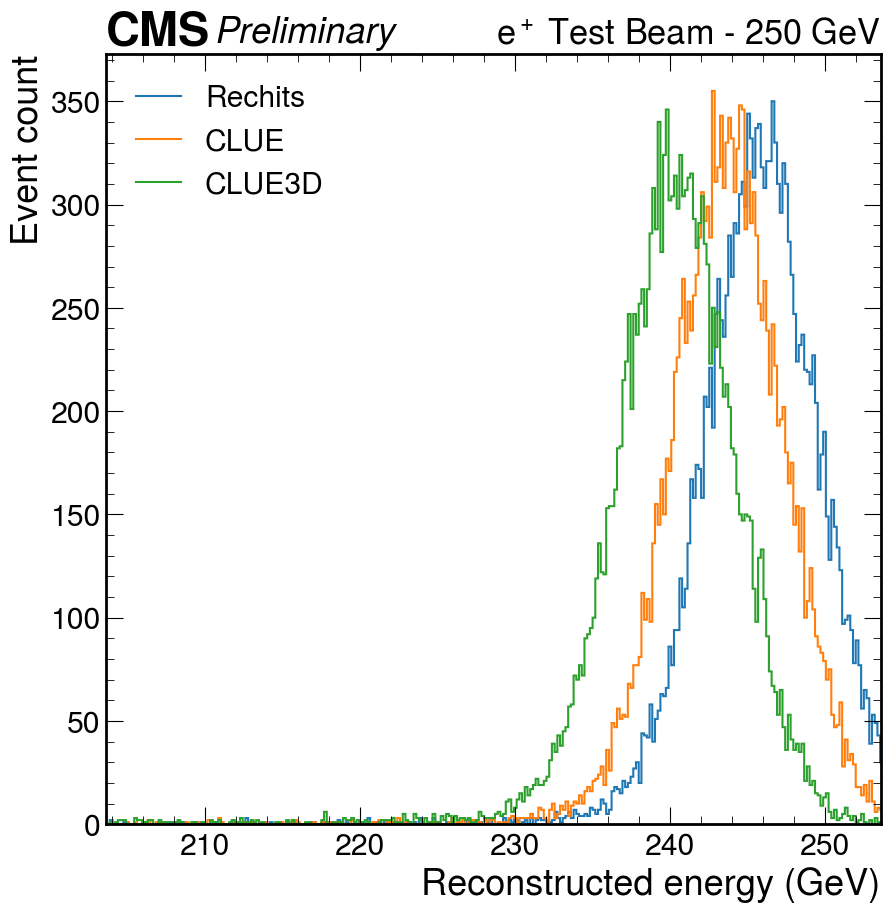

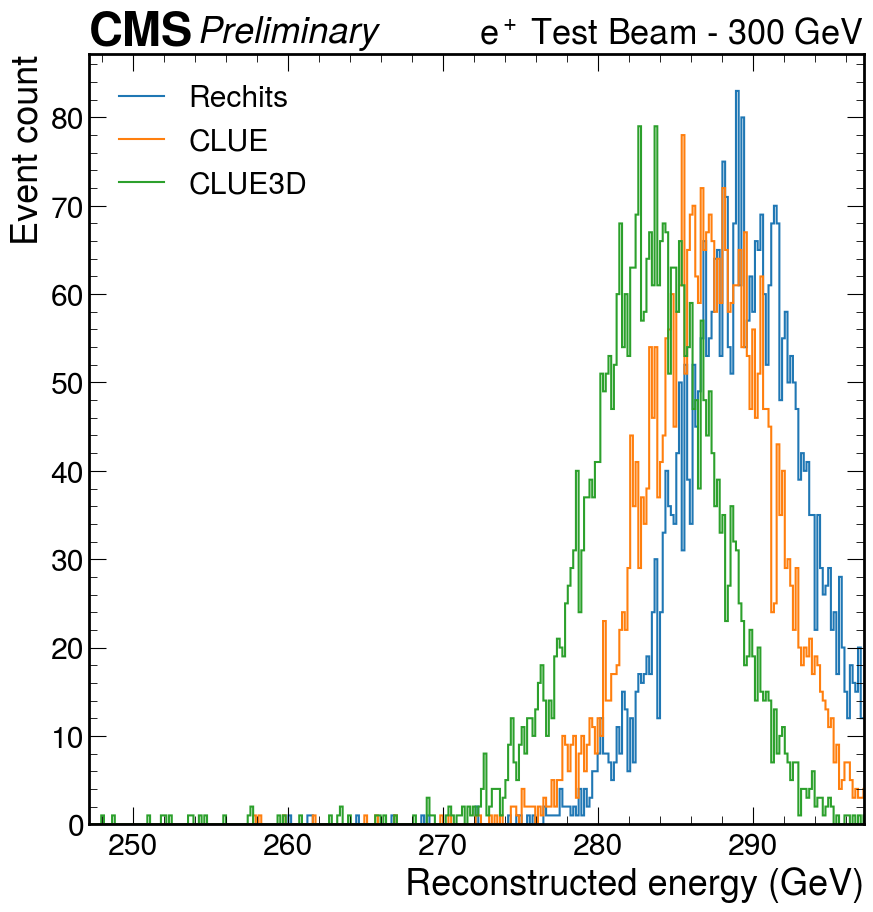

In [8]:
for beamEnergy in beamEnergies:
    plot("data", beamEnergy)

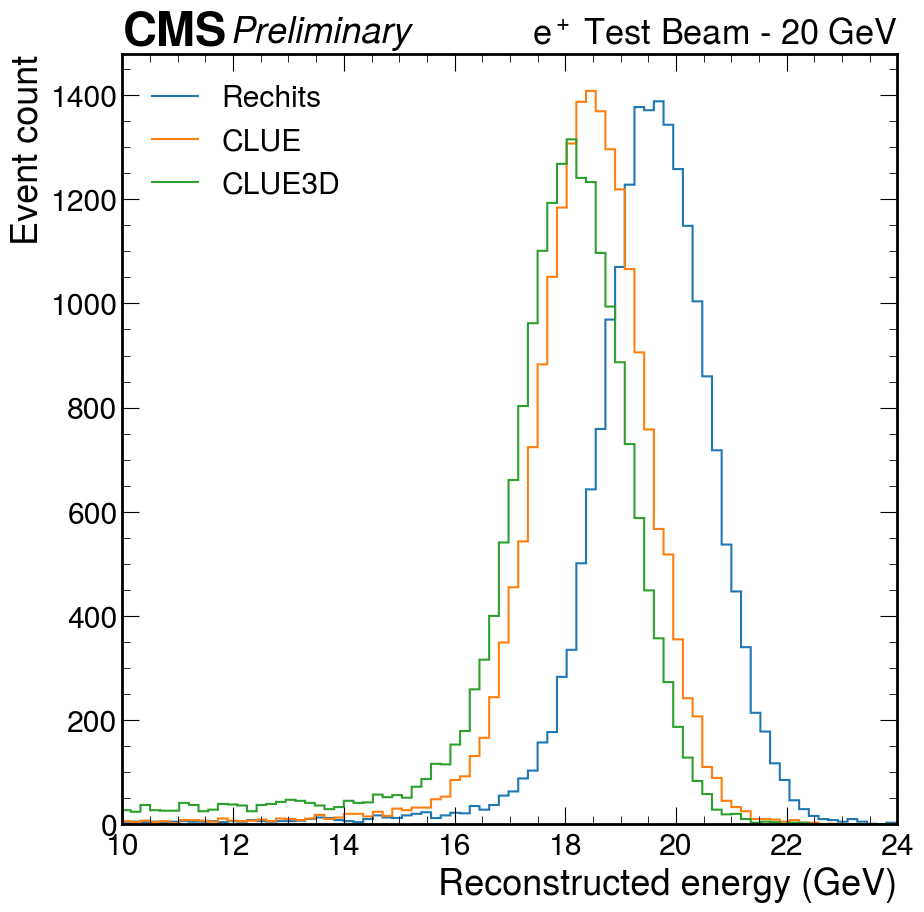

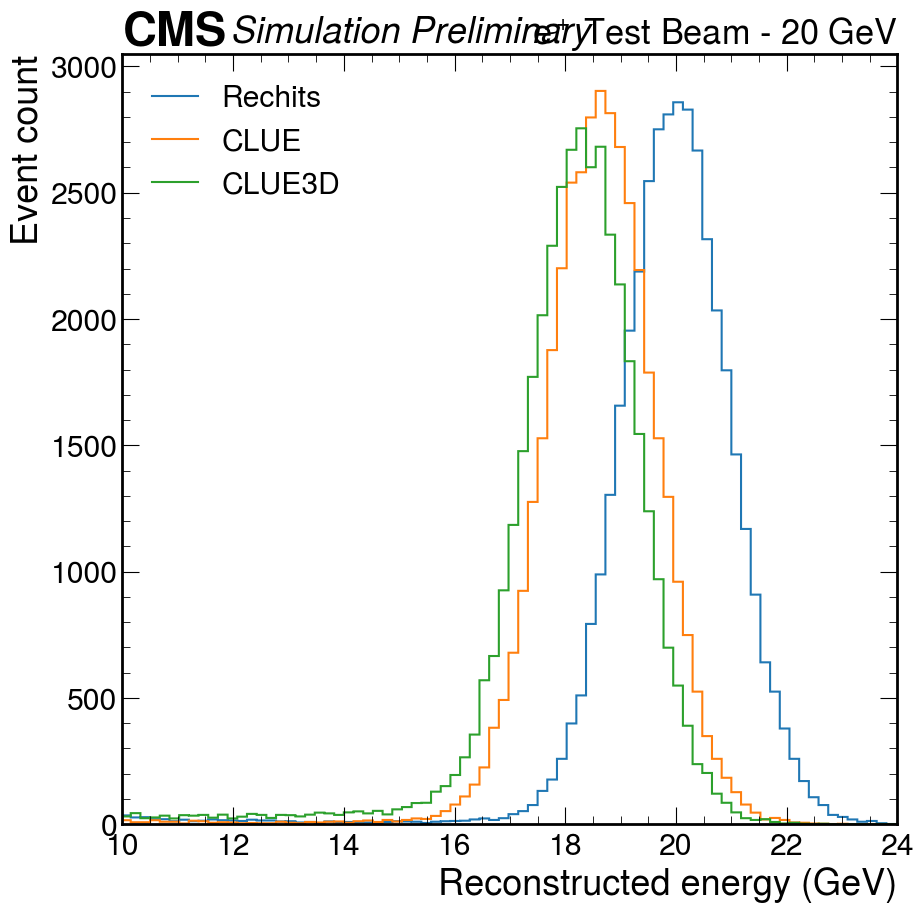

In [9]:
plot("data", 20, (10, 24))
plot("sim_proton_v46_patchMIP", 20, (10, 24))

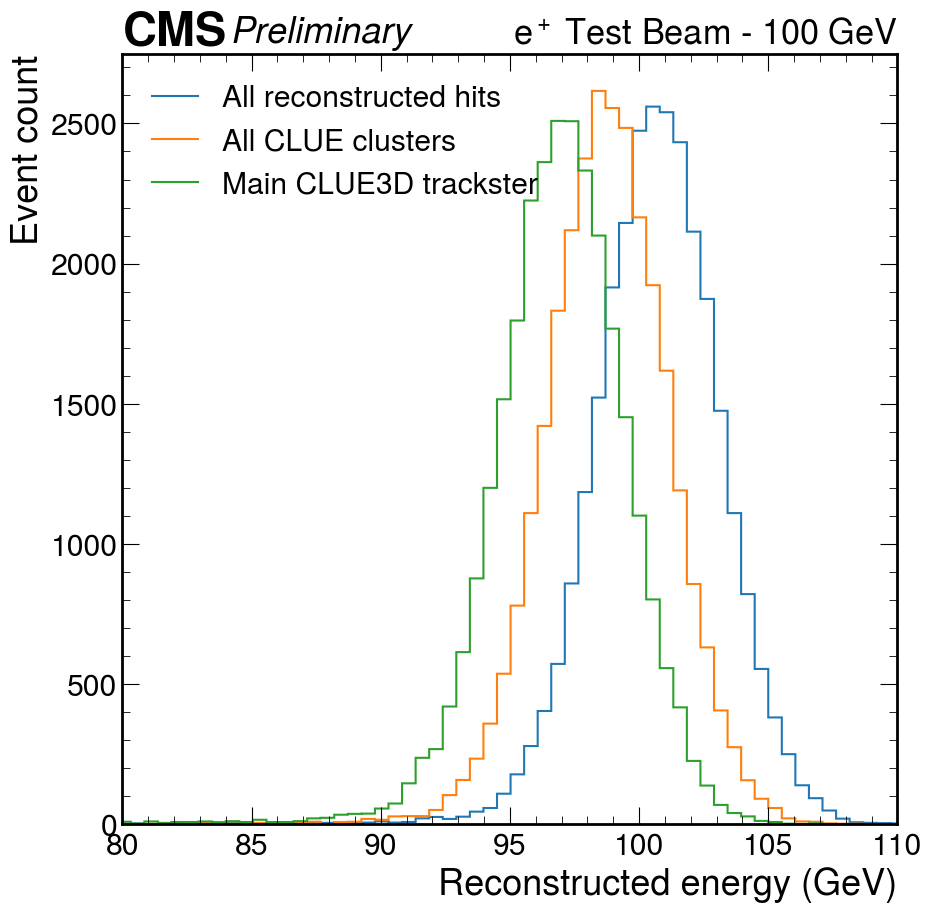

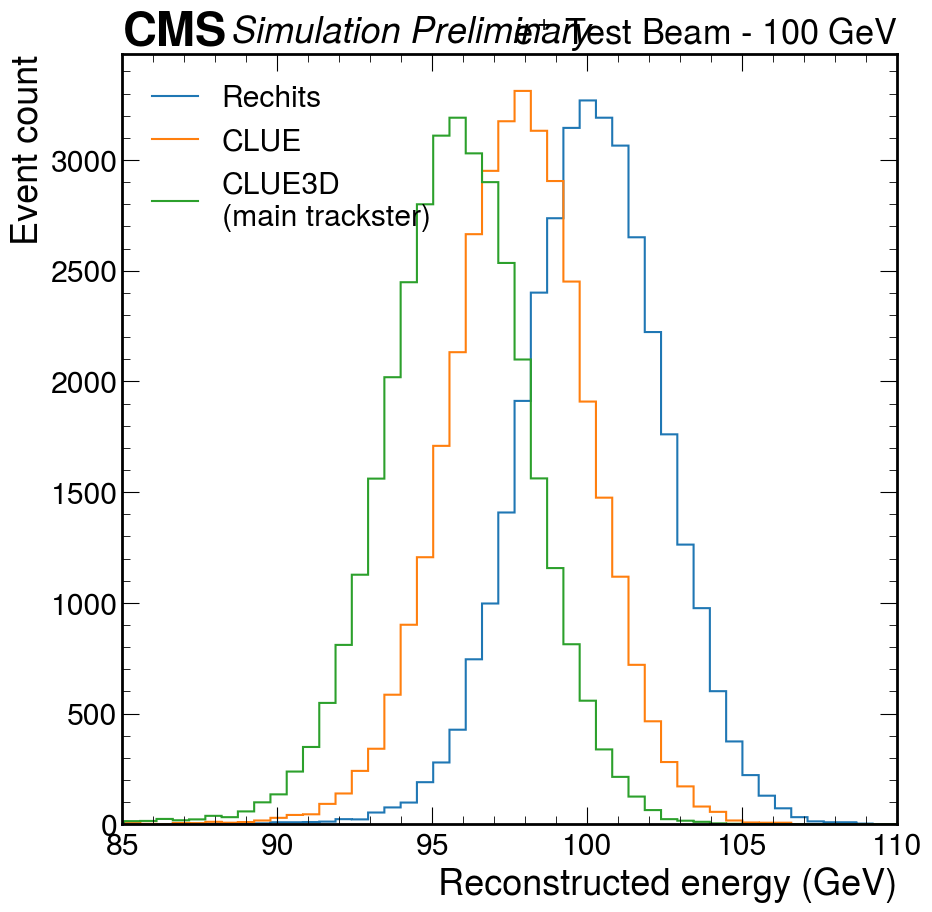

In [10]:
plot("data", 100, (80, 110), rebin=3, mainTrackster=True, labels=["All reconstructed hits", "All CLUE clusters", "Main CLUE3D trackster"])
#plt.savefig("plots/rechits-clue3d-energy/data-100.pdf", bbox_inches="tight")
plot("sim_proton_v46_patchMIP", 100, (85, 110), rebin=3, mainTrackster=True)
#plt.savefig("plots/rechits-clue3d-energy/sim-100.pdf", bbox_inches="tight")

In [11]:
def plotForApproval(beamEnergy=100, datatype="data", xLim=(80, 110), rebin=3, mpvs=None):
    labels=["Reconstructed hits", "CLUE clusters", "Main CLUE3D\ntrackster"]
    if mpvs is not None:
        for i in range(len(labels)):
            labels[i] += f"\nMPV = {mpvs[i]:.1f} GeV"
    plt.figure(figsize=(8, 8))
    plt.xlim(xLim)
    hists = [getRechitsProjected(datatype, beamEnergy), getClue2DProjected(datatype, beamEnergy), getClue3DProjected(datatype, beamEnergy)]
    if rebin is not None:
        for i in range(len(hists)):
            hists[i] = hists[i][::hist.tag.rebin(rebin)]

    hep.histplot(hists, 
        yerr=False, label=labels,
        color=colors_cycle, flow="none"
        )
    plt.ylabel("Event count")
    if datatype == "data":
        hep.cms.text("Preliminary", loc=0)
    else:
        hep.cms.text("Simulation Preliminary", loc=0)
    import matplotlib
    plt.text(
        x=0.05, y=0.95, va="top",
            s="$e^+$ Test Beam\n"+ str(beamEnergy) + " GeV",
            transform=plt.gca().transAxes,
            ha="left",
            fontsize=matplotlib.rcParams["font.size"] * 0.9,
            fontweight="normal",
            fontname="TeX Gyre Heros"
        )
    plt.legend(loc='upper left', prop={'size': 18}, bbox_to_anchor=(0, 0.85))

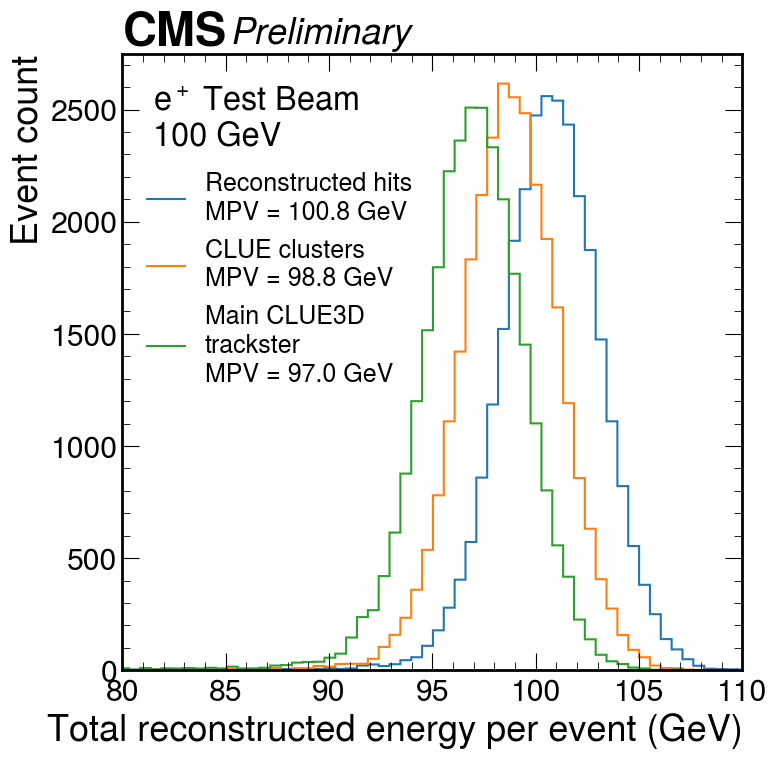

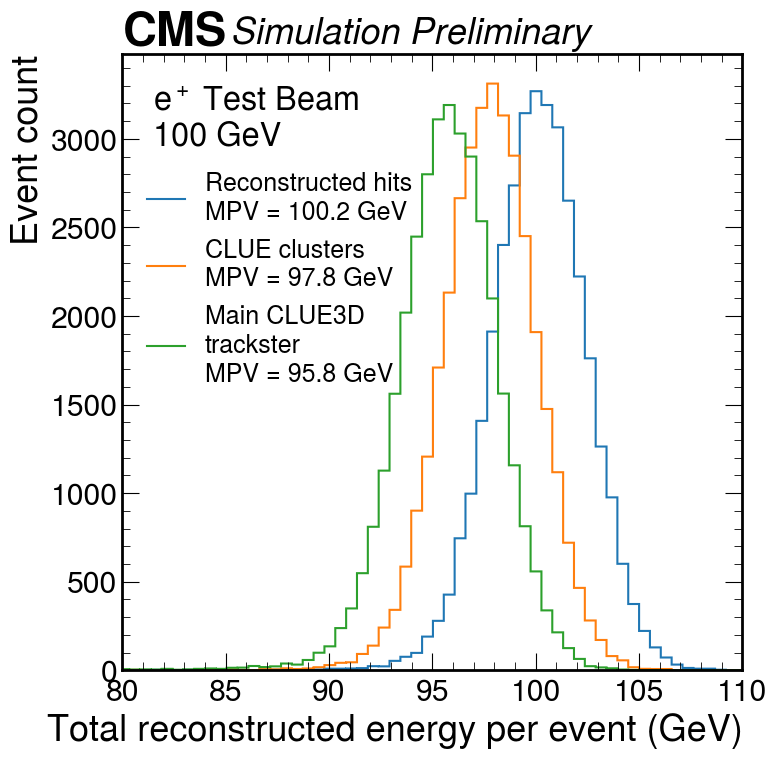

In [12]:
plotForApproval(100, "data", rebin=3, xLim=(80, 110), mpvs=[100.75503370013011, 98.76297914199202, 97.04767863359666])
plt.savefig("plots/rechits-clue3d-energy/data-100-small.pdf", bbox_inches="tight")
plotForApproval(100, "sim_proton_v46_patchMIP",rebin=3, xLim=(80, 110), mpvs=[100.18750585673688, 97.81271856576174, 95.8416127683375])
plt.savefig("plots/rechits-clue3d-energy/sim-100-small.pdf", bbox_inches="tight")

In [13]:
def plotForApprovalDataSim(beamEnergy=100, xLim=(80, 110), ratio=True, rebin=3):
    labels=["Reconstructed hits", "CLUE clusters", "Main CLUE3D\ntrackster"]

    fig = plt.figure(figsize=(8, 10) if ratio else (8,8))
    if ratio:
        grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

        main_ax = fig.add_subplot(grid[0])
        subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
        plt.setp(main_ax.get_xticklabels(), visible=False)
    else:
        main_ax = fig.subplots()

    main_ax.set_xlim(xLim)
    hists_data = [getRechitsProjected("data", beamEnergy), getClue2DProjected("data", beamEnergy), getClue3DProjected("data", beamEnergy)]
    if rebin is not None:
        for i in range(len(hists_data)):
            hists_data[i] = hists_data[i][::hist.tag.rebin(rebin)]

    hists_sim = [getRechitsProjected("sim_proton_v46_patchMIP", beamEnergy), getClue2DProjected("sim_proton_v46_patchMIP", beamEnergy), getClue3DProjected("sim_proton_v46_patchMIP", beamEnergy)]
    
    for i in range(len(hists_sim)):
        if rebin is not None:
            hists_sim[i] = hists_sim[i][::hist.tag.rebin(rebin)]
        hists_sim[i] = hists_sim[i] * hists_data[i].sum() / hists_sim[i].sum() # norm sim to data

    hep.histplot(hists_data, 
        yerr=False, label=labels, #["Energy reconstructed", "Energy clustered by CLUE", "Energy clustered by CLUE3D"]
        color=colors_cycle, flow="none", ax=main_ax
        )
    hep.histplot(hists_sim, 
        yerr=False, label=labels, #["Energy reconstructed", "Energy clustered by CLUE", "Energy clustered by CLUE3D"]
        color=colors_cycle, flow="none", linestyle="dashed", ax=main_ax
        )
    main_ax.set_ylabel("Event count")
    hep.cms.text("Preliminary", loc=0, ax=main_ax)
    hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)
    import matplotlib
    main_ax.text(
        x=0.05, y=0.95, va="top",
            s= str(beamEnergy) + " GeV",
            transform=plt.gca().transAxes,
            ha="left",
            fontsize=matplotlib.rcParams["font.size"] * 0.9,
            fontweight="normal",
            fontname="TeX Gyre Heros"
        )
    main_ax.legend(loc='upper left', prop={'size': 18}, bbox_to_anchor=(0, 0.85))

    if ratio:
        for h_data, h_sim, color in zip(hists_data, hists_sim, colors_cycle):
            subplot_ax.plot(h_data.axes[0].centers, h_data.values()/h_sim.values(), 'o', color=color)
        subplot_ax.set_ylim(0, 3)

/tmp/ipykernel_5655/790950738.py:52: RuntimeWarning: divide by zero encountered in divide
  subplot_ax.plot(h_data.axes[0].centers, h_data.values()/h_sim.values(), 'o', color=color)
/tmp/ipykernel_5655/790950738.py:52: RuntimeWarning: invalid value encountered in divide
  subplot_ax.plot(h_data.axes[0].centers, h_data.values()/h_sim.values(), 'o', color=color)


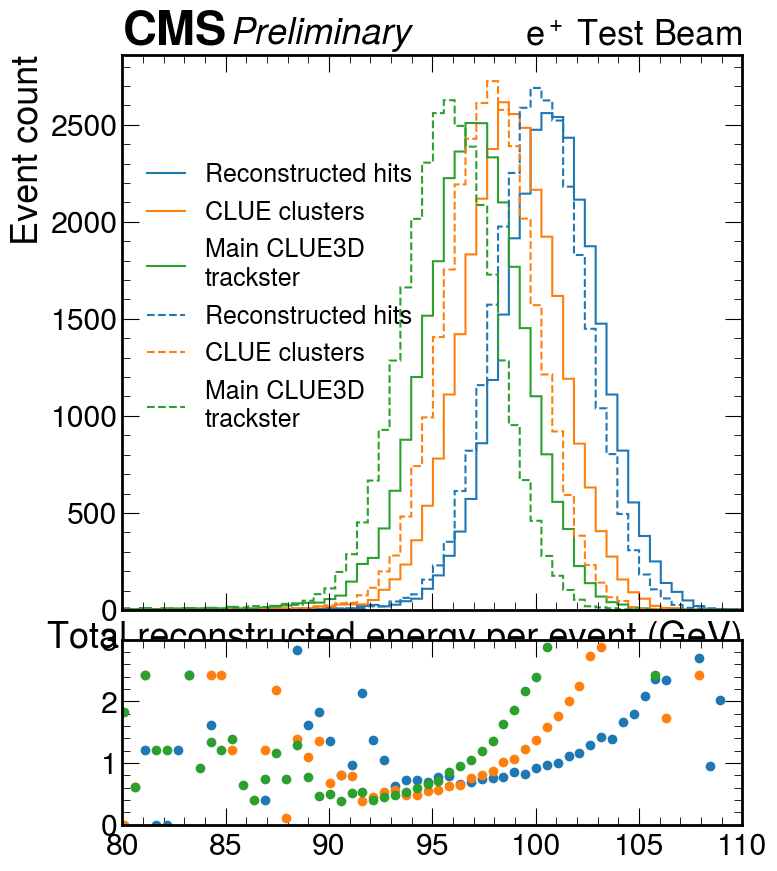

In [14]:
plotForApprovalDataSim()